In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import pickle
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
MultivariateNormalDiag = tfp.distributions.MultivariateNormalDiag
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files
from sklearn.metrics import mean_squared_error
drive.mount('/content/gdrive')

2.8.0
Mounted at /content/gdrive


In [ ]:
###########################################
#VAE class
###########################################

class VariationalAutoencoder:
  def __init__(self, in_size, hid_size, latent_size):
    dense_1 = Dense(hid_size,activation="relu")
    dense_2 = Dense(latent_size)  #For the final encoder layer, activation is linear
    dense_3 = Dense(latent_size)
    dense_4 = Dense(hid_size, activation="relu")
    dense_5 = Dense(in_size)

    #Encoder 
    X = Input(shape=(in_size,))
    encode_1 = dense_1(X)
    encode_2 = dense_2(encode_1)
    encode_3 = dense_3(encode_1)

    #Get sigma (standard dev) > 0 from an unbounded variable by passing it through the softplus function.
    means = encode_2[:,:latent_size]
    stddev = tf.nn.softplus(encode_3[:,:latent_size]) + 1e-6

    #Tensorflow random sampling
    xi = MultivariateNormalDiag(loc=tf.zeros([latent_size,]),scale_diag=tf.ones([latent_size,])).sample()
    Z = means + stddev * xi

    #Decoder
    decode_1 = dense_4(Z)
    decode_2 = dense_5(decode_1)

    outputs = tf.concat([decode_2, means, stddev],axis=1)
    
    def loss(y_true,y_pred):
      decode = y_pred[:,:in_size]
      means = y_pred[:,in_size:in_size+latent_size]
      stddev = y_pred[:,in_size+latent_size:in_size+latent_size*2]
      expected_log_likelihood = -tf.reduce_sum(tf.square(decode-y_true),1)
      kl = tf.reduce_sum(-tf.math.log(stddev) + 0.5*(tf.square(stddev)+ tf.square(means))-0.5, axis=1)
      elbo = tf.reduce_sum(expected_log_likelihood-kl)
      return -elbo
  
    self.VAE = Model(inputs=X,outputs=outputs)
    self.VAE.compile(loss=loss, optimizer='adam') 

    #Create the encoder model
    self.encoder = Model(inputs=X,outputs=means)
    self.post_sd_network = Model(inputs=X,outputs=stddev)

    #Create the decoder model
    code_input = Input(shape=(latent_size,)) 
    decode_3 = dense_4(code_input)
    decode_4 = dense_5(decode_3)
    self.decoder = Model(inputs=code_input,outputs=decode_4)
  

In [ ]:
###########################################
#MNIST Example
###########################################
#Load in the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
x_train = x_train.reshape(60000, 784)
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_train)  #Fit the standard scaler
x_train_scaled = scaler.transform(x_train) #Scale the data

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
VAE_MNIST = VariationalAutoencoder(784,0.5*784,2)

In [ ]:
r=VAE_MNIST.VAE.fit(x_train_scaled,x_train_scaled,epochs=30,batch_size=32,shuffle=True)

Epoch 1/30
1875/1875 [==============================] - 10s 3ms/step - loss: 29798.9805
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 20699.5566
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 19662.8223
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 21173.4004
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 20041.8164
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 20478.5996
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 20421.6211
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 23580.3145
Epoch 9/30
1875/1875 [==============================] - 7s 4ms/step - loss: 22461.3613
Epoch 10/30
1875/1875 [==============================] - 6s 3ms/step - loss: 18966.8594
Epoch 11/30
1875/1875 [==============================] - 8s 5ms/step - loss: 18447.5273
Epoch 12/30
1875/1875 [=================

In [ ]:
#Plot what image is reproduced for different parts of Z
n = 19 # number of images per side
x_values = np.linspace(-3,3,n)
y_values = np.linspace(-3,3,n)
image = np.empty((28*n,28*n))

#build Z first so we don't have to keep re-calling the predict function
Z2 = []
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    z = [x,y]
    Z2.append(z)
X_recon = scaler.inverse_transform(VAE_MNIST.decoder.predict(Z2))

k = 0
for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    x_recon = X_recon[k]
    k += 1
    #convert from NxD == 1 x 784 --> 28 x 28
    x_recon = x_recon.reshape(28, 28)
    image[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = (x_recon > 0.4)

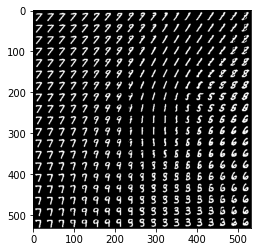

In [ ]:
plt.imshow(image, cmap='gray')

In [7]:
##########################################################################################
#Train the VAE using simulated embankment responses
##########################################################################################

#Load the simulated responses
M0 = np.array(pd.read_csv('/content/gdrive/My Drive/M0_simulated.csv',header=0))[:,1:301]
M1 = np.array(pd.read_csv('/content/gdrive/My Drive/M1_simulated.csv',header=0))[:,1:301]
M2 = np.array(pd.read_csv('/content/gdrive/My Drive/M2_simulated.csv',header=0))[:,1:301]
M3 = np.array(pd.read_csv('/content/gdrive/My Drive/M3_simulated.csv',header=0))[:,1:301]
HPG1_1 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_1_simulated.csv',header=0))[:,1:301]
HPG1_2 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_2_simulated.csv',header=0))[:,1:301]
HPG1_3 = np.array(pd.read_csv('/content/gdrive/My Drive/HPG1_3_simulated.csv',header=0))[:,1:301]
VWP6b = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6b_ex_simulated.csv',header=0))[:,1:301]
VWP6c = np.array(pd.read_csv('/content/gdrive/My Drive/VWP6c_ex_simulated.csv',header=0))[:,1:301]

#Split into training and testing dataset
x_data = np.vstack((M0,M1,M2,M3,HPG1_1,HPG1_2,HPG1_3,VWP6b,VWP6c)).T
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)
print("x_data.shape:",x_data.shape)
print("x_train.shape:",x_train.shape)
print("x_test.shape:",x_test.shape)

#Scale the data using standardscalar
scaler = StandardScaler() #Initialize the standardscaler
scaler.fit(x_train)  #Fit the standard scaler
x_train_scaled = scaler.transform(x_train) #Scale the data
x_test_scaled = scaler.transform(x_test)
x_scaled = scaler.transform(x_data)
with open(f'scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)  #Save the standard scalar

x_data.shape: (300, 1170)
x_train.shape: (240, 1170)
x_test.shape: (60, 1170)


In [12]:
#Reconstruction error against number of latent nodes
#reconstruct_err_train = np.zeros(10)
#reconstruct_err_test = np.zeros(10)
for i in range (5,6):
  VAE_trial = VariationalAutoencoder(1170,0.5*1170,i)
  r=VAE_trial.VAE.fit(x_train_scaled,x_train_scaled,epochs=1000,batch_size=32,shuffle=True)
  #Evalute reconstruction error
  reconstructed_train = VAE_trial.VAE.predict(x_train_scaled)[:,:1170]
  reconstruct_err_train[i-1]= mean_squared_error(x_train_scaled,reconstructed_train[:,:1170])
  reconstructed_test = VAE_trial.VAE.predict(x_test_scaled)[:,:1170]
  reconstruct_err_test[i-1]= mean_squared_error(x_test_scaled,reconstructed_test[:,:1170]) 

Epoch 1/1000
8/8 [==============================] - 1s 5ms/step - loss: 34003.7930
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 12489.3486
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 7195.0200
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 5438.9243
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 6203.8843
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 7540.5332
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 7314.4888
Epoch 8/1000
8/8 [==============================] - 0s 5ms/step - loss: 5475.6323
Epoch 9/1000
8/8 [==============================] - 0s 5ms/step - loss: 4365.1025
Epoch 10/1000
8/8 [==============================] - 0s 5ms/step - loss: 3995.1978
Epoch 11/1000
8/8 [==============================] - 0s 5ms/step - loss: 3566.6921
Epoch 12/1000
8/8 [==============================] - 0s 5ms/step - loss: 3097.1416
Epoch 13/10

[0.19355601 0.04632643 0.03142777 0.00677146 0.00446334 0.00281482
 0.00232179 0.00183055 0.0097006  0.00233914]
[0.25953119 0.0624673  0.04730401 0.01968912 0.01367986 0.00405471
 0.00493734 0.00272606 0.00809107 0.00309118]


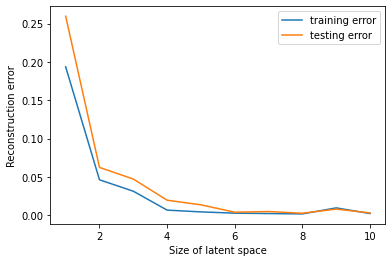

In [13]:
print(reconstruct_err_train)
print(reconstruct_err_test)
plt.plot(range(1,11),reconstruct_err_train,label='training error')
plt.plot(range(1,11),reconstruct_err_test,label='testing error')
plt.xlabel('Size of latent space')
plt.ylabel('Reconstruction error') 
plt.legend()

In [18]:
#Find out the best epoch for VAE training
VAE_t = VariationalAutoencoder(1170,0.5*1170,6)
err_train = np.zeros(50)
err_test = np.zeros(50)
for i in range (1,51):
  r=VAE_t.VAE.fit(x_train_scaled,x_train_scaled,validation_data=(x_test_scaled,x_test_scaled),epochs=100,batch_size=32,shuffle=True)
  reconstructed_train = VAE_t.VAE.predict(x_train_scaled)[:,:1170]
  err_train[i-1]= mean_squared_error(x_train_scaled,reconstructed_train[:,:1170])
  reconstructed_test = VAE_t.VAE.predict(x_test_scaled)[:,:1170]
  err_test[i-1]= mean_squared_error(x_test_scaled,reconstructed_test[:,:1170]) 

串流輸出內容已截斷至最後 5000 行。
8/8 [==============================] - 0s 14ms/step - loss: 3387.0164 - val_loss: 2871.1870
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 2773.3606 - val_loss: 2374.4915
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 2236.2759 - val_loss: 2099.6956
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 2078.9702 - val_loss: 1891.8043
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 1782.7046 - val_loss: 1718.4686
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 1505.7896 - val_loss: 1641.7893
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 1346.4679 - val_loss: 1344.5078
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 1130.7302 - val_loss: 1254.8765
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 1042.9978 - val_loss: 1202.7056
Epoch 10/100
8/8 [==============================] - 0s 8ms/step

1000

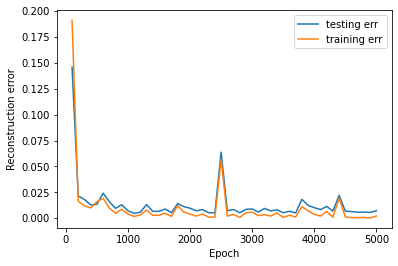

In [25]:
plt.plot(100*np.linspace(1,50,50), err_test, label = 'testing err')
plt.plot(100*np.linspace(1,50,50), err_train, label = 'training err')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction error') 
plt.legend()
print(np.argmin(err_test)*100)

In [26]:
#Fit the final VAE model
VAE_final = VariationalAutoencoder(1170,0.5*1170,6)
r=VAE_final.VAE.fit(x_train_scaled,x_train_scaled,validation_data=(x_test_scaled,x_test_scaled),epochs=1000,batch_size=32,shuffle=True)

Epoch 1/1000
8/8 [==============================] - 1s 44ms/step - loss: 35218.3008 - val_loss: 16358.2100
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 13758.0098 - val_loss: 7909.4600
Epoch 3/1000
8/8 [==============================] - 0s 13ms/step - loss: 9076.6387 - val_loss: 6836.1387
Epoch 4/1000
8/8 [==============================] - 0s 10ms/step - loss: 7057.1865 - val_loss: 5840.4595
Epoch 5/1000
8/8 [==============================] - 0s 10ms/step - loss: 5880.7109 - val_loss: 4591.2007
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 4894.3403 - val_loss: 4097.1631
Epoch 7/1000
8/8 [==============================] - 0s 9ms/step - loss: 4028.6206 - val_loss: 3782.4702
Epoch 8/1000
8/8 [==============================] - 0s 10ms/step - loss: 4370.8096 - val_loss: 4966.1475
Epoch 9/1000
8/8 [==============================] - 0s 10ms/step - loss: 4391.1099 - val_loss: 3507.9155
Epoch 10/1000
8/8 [==============================] - 0

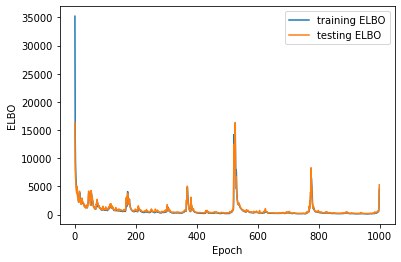

In [27]:
#Plot the ELBO
plt.plot(r.history['loss'], label = 'training ELBO')
plt.plot(r.history['val_loss'], label = 'testing ELBO')
plt.xlabel('Epoch')
plt.ylabel('ELBO') 
plt.legend()

In [28]:
#Save the encoder and decoder model
VAE_final.encoder.save_weights('/content/gdrive/My Drive/encoder_vae.h5') #Save the weights of the encoder
VAE_final.post_sd_network.save_weights('/content/gdrive/My Drive/post_sd_vae.h5') #Save the weights of the SD network
VAE_final.decoder.save_weights('/content/gdrive/My Drive/decoder_vae.h5') #Save the weights of the decoder